In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import pydna
from Bio import AlignIO
from scipy.stats import mannwhitneyu

In [2]:
aav2_selection_dir = '../analysis/selection_values/'
output_dir = '../analysis/output_figures/'

In [3]:
# Make a table that contains aa position and aa identity for all rep sequences in the alignment
rep_alignment = AlignIO.parse('../analysis/input_files/rep_protein_sequences_alignment.phy','phylip')

def calculate_aligment_positions(alignment_in):
    alignment_obj = []
    alignment_df = pd.DataFrame()
    for alignment in alignment_in:
        for idx, seq_obj in enumerate(alignment):
            protein_position = 1
            for alignment_position, aa in enumerate(seq_obj.seq):
                if aa == '-':
                    protein_position_write = 0
                else:
                    protein_position_write = protein_position
                alignment_obj.append({'align_pos':alignment_position+1,
                                      '%s_pos' % seq_obj.id :protein_position_write, 
                                      '%s_aa' % seq_obj.id: aa})
                if aa != '-':
                    protein_position +=1

            df = pd.DataFrame(alignment_obj)
            if idx == 0:
                alignment_df = pd.DataFrame(alignment_obj)
            else:
                alignment_df = alignment_df.merge(df, on=['align_pos'], how='left')
            alignment_obj = []
    return alignment_df.set_index('align_pos')

alignment_df = calculate_aligment_positions(rep_alignment)
alignment_df.head()

AAV1_Rep_pos AAV1_Rep_aa  AAV2_Rep_pos AAV2_Rep_aa  AAV3_rep_pos  \
align_pos                                                                     
1                     1           M             1           M             1   
2                     2           P             2           P             2   
3                     3           G             3           G             3   
4                     4           F             4           F             4   
5                     5           Y             5           Y             5   

          AAV3_rep_aa  AAV4_rep_pos AAV4_rep_aa  AAV5_Rep_pos AAV5_Rep_aa  \
align_pos                                                                   
1                   M             1           M             1           M   
2                   P             2           P             2           A   
3                   G             3           G             3           T   
4                   F             4           F             4           F   
5                   Y             5           Y             5           Y   

           ...  AAV8_Rep_pos AAV8_Rep_aa  AAV10_Rep_pos AAV10_Rep_aa  \
align_pos  ...                                                         
1          ...             1           M              1            M   
2          ...             2           P              2            P   
3          ...             3           G              3            G   
4          ...             4           F              4            F   
5          ...             5           Y              5            Y   

           AAV11_Rep_pos AAV11_Rep_aa  AAV12_Rep_pos AAV12_Rep_aa  \
align_pos                                                           
1                      1            M              1            M   
2                      2            P              2            P   
3                      3            G              3            G   
4                      4            F              4            F   
5                      5            Y              5            Y   

           AAV13_Rep_pos AAV13_Rep_aa  
align_pos                              
1                      1            M  
2                      2            P  
3                      3            G  
4                      4            F  
5                      5            Y  

[5 rows x 24 columns]

In [4]:
# Generate a table with all the different aa relative to AAV2 rep aa sequence and positions
def get_residue_differences(alignment_df):
    aav_diffs = []

    for idx, row in alignment_df.iterrows():
        aav2_aa = row['AAV2_Rep_aa']
        aav2_pos = row['AAV2_Rep_pos']
        for sidx, val in row.items():
            if type(val) is str:
                if val != aav2_aa:
                    aav_diffs.append({'pos': aav2_pos, 'aa': val})
    return pd.DataFrame(aav_diffs).drop_duplicates()

differences_aav_seroptypes_df = get_residue_differences(alignment_df)
differences_aav_seroptypes_df.drop_duplicates(subset=['aa', 'pos'], inplace=True)
differences_aav_seroptypes_df.head()   

pos aa
0    2  A
1    3  T
2    7  V
4    8  I
5    9  L

In [5]:
# Read in df with aa-level selection values for Rep78/68 library (with AAV2 capsid)
aav2_selection_aa_df = pd.read_csv(aav2_selection_dir + 'rep7868_selection_values_aa_trans.csv',
                                 header=[0], index_col=[0,1,2,3], skipinitialspace=True)
aav2_selection_aa_df.columns = (['aav2'])
aav2_selection_aa_df.head()

aav2
abs_pos aa is_wt_aa lib_type          
1       *  0        del       0.573863
                    sub       0.568310
        A  0        sub       0.770925
        C  0        sub       0.725970
        D  0        sub       0.583527

In [6]:
# Generate df that contains selection values for only those aa mutations found in diff_df
# and generate another df that contains selection values for only those aa mutations NOT found in diff_df
def subset_fitness_residues(diff_df, fitness_df):
    serotype_fitness_df = pd.DataFrame()
    aav2_only_fitness_df = aav2_selection_aa_df
    for idx, row in diff_df.iterrows():
#         print (row)
        if row['aa'] == '-':
            continue
        if row['pos'] == 0:
            continue
        value = fitness_df.xs((row['aa'], row['pos']), level=['aa', 'abs_pos'], drop_level=False)
#         print (value)
        serotype_fitness_df = pd.concat([serotype_fitness_df, value])
        aav2_only_fitness_df.drop((row['pos'], row['aa']), axis=0, inplace=True)
    return serotype_fitness_df, aav2_only_fitness_df

conserved_fitness_df, aav2_unique_fitness_df = subset_fitness_residues(differences_aav_seroptypes_df, aav2_selection_aa_df)

conserved_fitness_df.head()

aav2
abs_pos aa is_wt_aa lib_type          
2       A  0        sub       0.999640
3       T  0        sub       0.810370
7       V  0        sub       0.883062
8       I  0        sub       1.133326
9       L  0        sub       1.261049

In [7]:
aav2_unique_fitness_df.head()

aav2
abs_pos aa is_wt_aa lib_type          
1       *  0        del       0.573863
                    sub       0.568310
        A  0        sub       0.770925
        C  0        sub       0.725970
        D  0        sub       0.583527

In [8]:
conserved_mut = conserved_fitness_df['aav2'].dropna().apply(np.log2).reset_index()
conserved_mut['type'] = 'conserved'

aav2_unique = aav2_unique_fitness_df['aav2'].dropna().apply(np.log2).reset_index()
aav2_unique['type'] = 'library only'

all_mut = aav2_selection_aa_df['aav2'].dropna().apply(np.log2).reset_index()
all_mut['type'] = 'all library variants'

data_for_violin_plt = pd.concat([conserved_mut, aav2_unique])
data_for_violin_plt = data_for_violin_plt.replace([np.inf, -np.inf], np.nan)

data_for_violin_plt.head()

abs_pos aa  is_wt_aa lib_type      aav2       type
0        2  A         0      sub -0.000519  conserved
1        3  T         0      sub -0.303347  conserved
2        7  V         0      sub -0.179414  conserved
3        8  I         0      sub  0.180563  conserved
4        9  L         0      sub  0.334624  conserved

In [9]:
# perform mann whitney u test
conserved = data_for_violin_plt[data_for_violin_plt['type'] == 'conserved']['aav2']
library_only = data_for_violin_plt[data_for_violin_plt['type'] != 'conserved']['aav2']
print (library_only)
stat, p_value = mannwhitneyu(conserved, library_only)
print('Statistics=%.2f, p=%.40f' % (stat, p_value))

0       -0.801223
1       -0.815250
2       -0.375338
3       -0.462017
4       -0.777130
           ...   
13288   -0.022420
13289    0.026308
13290    0.013632
13291   -0.193724
13292   -0.283113
Name: aav2, Length: 13293, dtype: float64
Statistics=nan, p=nan


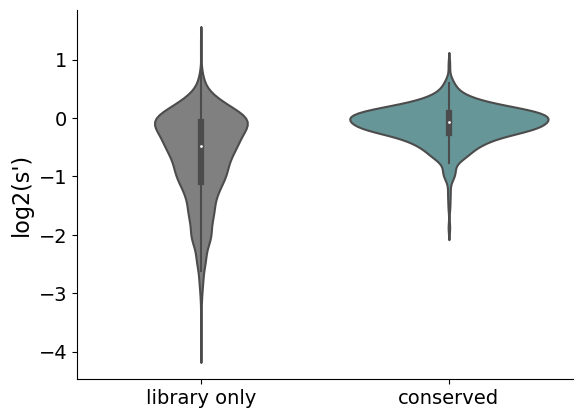

In [10]:
# Generate violin plot comparing selection values for mutations found in different serotypes to selection values for all variants
my_pal = {"conserved": "cadetblue", "library only": "grey"}
sns.violinplot(x='type', y='aav2', data=data_for_violin_plt, figsize=(10,5), palette=my_pal, order=['library only', 'conserved'])

plt.ylabel('log2(s\')', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig('../analysis/output_figures/conserved_vs_library_violin_plot.png')
plt.show()

In [11]:
# Determine how many variants with s' > 1 are found in other variants
better_than_wt = aav2_selection_aa_df[aav2_selection_aa_df['aav2'] > 1]
better_than_wt.drop(1, level=2, axis=0, inplace=True)
print (len(better_than_wt.index))

better_than_wt.head()

2353


aav2
abs_pos aa is_wt_aa lib_type          
1       Q  0        sub       1.080776
2       *  0        del       1.329173
        C  0        sub       1.038088
        F  0        sub       1.388581
        G  0        sub       1.109198